In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021) and the empirical evaluation follows https://migariane.github.io/TMLE.nb.html

$\psi(P_0) = \mathbb{E}[\mathbb{E}[Y|X=1, Z]]$  is our target estimand - it is the potential outcome mean, i.e. the outcome $Y$ under treatment $X=1$ given covariates $Z$.

i.e. $$\psi(P_0) = \int y f(y|1,z)f(z) dy dz$$

Which is the statistical estimand of the mean of $Y^1$ (the quantity is identifiable).

If we assume the distribution from which the densities $f$ derive has been perturbed by a point mass at $(\tilde x, \tilde y, \tilde z)$ then:

$$\psi(P_0) = \int y f_t(y|1,z)f_t(z) dy dz$$

$$ = \int y \frac{f_t(y,1,z)f_t(z)}{f_t(1,z)} dy dz$$

Under the 'parametric submodel' $$P_t = t\delta_x(\tilde x) + (1-t)P_o$$ and where $\delta_x(\tilde x)$ denotes the Dirac delta function s.t. it gives the density of a point mass at $\tilde x$, is zero everywhere else, and integrates to 1.

For our densities we therefore have that:

$$f_t(x,y,z) =  t \delta_{x,y,z}(\tilde x, \tilde y, \tilde z) +  (1-t)f(x,y,z)$$

and, equivalently for $f_t(z)$ and $f_t(1,z)$.

Following the derivation in the paper, the efficient influence function is given as:

$$ \phi_1 = \left . \frac{d\psi (P_t)}{dt} \right \vert_{t=0} = \frac{\mathbb{1}_1(\tilde x)}{\pi(\tilde z,  P)}\{\tilde y - \mathbb{E}(Y|X=1, Z=z)\} + \mathbb{E}(Y|X=1, Z=z) - \psi(P_0)$$

This can be combined with the outcome under no treatment $x=0$ to derive the influence curve for the average treatment effect:

$$\phi_{ATE}=  \phi_1 - \phi_0 - \psi_{ATE}$$

In the expression above, there are a number of 'ground truth' quantities which we need to estimate. Using plug-in estimators we have:


$$ \phi_1(\hat P_n) = \frac{\mathbb{1}_1(\tilde x)}{\pi(\tilde z,  \hat P)}\{\tilde y - m_1(Z, \hat P_n) \} + m_1(Z, \hat P_n) - \psi(\hat P_n)$$

i.e. we have estimators for the propensity score $\pi$, and estimators for the expected outcome $m_1 \approx \mathbb{E}[Y|X=1, Z=z]$

Finally, we want to update out estimate. This can be done a number of ways. E.g.:

$$ \psi(P_0) \approx \psi(\hat P_n) + \frac{1}{n}\sum_{i=1}^n\phi_1(O_i, \hat P_n)$$

Alternatively, we can follow the 'targeted learning' approach and tune the initial estimator for the outcome:

$$m1^* = m1 + \hat \epsilon \left ( \frac{1}{\pi(Z, \hat P_n)} \right ) $$

which solves the influence curve to be equal to zero (i.e. the efficient influence curve):

$$ 0 = \frac{1}{n}\sum_i^n \frac{\mathbb{1}_1(X_i)}{\pi(Z_i, \hat P_n)}\left \{ Y_i - m_1 - \hat \epsilon \frac{1}{\pi (Z_i, \hat P_n)}\right \}$$

This latter approach is the one used in this example.

In [2]:

def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

def generate_data(N):
    z1 = np.random.binomial(1, 0.5, (N,1))
    z2 = np.random.binomial(1, 0.65, (N,1))
    z3 = np.round(np.random.uniform(0, 4, (N,1)),3)
    z4 = np.round(np.random.uniform(0, 5, (N,1)),3)
    X = np.random.binomial(1, sigm(-0.4 + 0.2*z2 + 0.15*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y1 = np.random.binomial(1, sigm(-1 + 1 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y0 = np.random.binomial(1, sigm(-1 + 0 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y = Y1 * X + Y0 * (1-X)
    Z = np.concatenate([z1,z2,z3,z4],1)
    return Z, X, Y, Y1, Y0

In [86]:

num_runs = 200
reds = []
for i in range(num_runs):
    print('========= RUN {} ========='.format(i))
    N = 10000
    Z, x, y, Y1, Y0 = generate_data(N)
    x_int1 = np.ones_like(x)  # this is the 'intervention data'
    x_int0 = np.zeros_like(x)  # this is the 'intervention data'

    true_psi = (Y1-Y0).mean()

    Q = LogisticRegression().fit(np.concatenate([x,Z], 1), y[:,0])
    Q1 = np.clip(Q.predict_proba((np.concatenate([x_int1, Z], 1)))[:, 1:], a_min=0, a_max=1)
    Q0 = np.clip(Q.predict_proba((np.concatenate([x_int0, Z], 1)))[:, 1:], a_min=0, a_max=1)
    Q10 = np.clip(Q.predict_proba((np.concatenate([x, Z], 1)))[:, 1:], a_min=0, a_max=1)

    biased_psi = (Q1-Q0).mean()

    G = LogisticRegression().fit(Z, x[:,0])
    G10 = np.clip(G.predict_proba(Z), a_min=0, a_max=1)[:, 1:]

    H1 = (1/(G10))
    H0 = - (1 / (1 - G10))
    H10 = x * (1/G10) - (1-x)*(1/(1-G10))

    epsilon = sm.GLM(y, H10, offset=inv_sigm(Q10[:,0]), family=sm.families.Binomial()).fit().params

    Q10_star = sigm(inv_sigm(Q10) + epsilon * (H10))
    Q1_star = sigm(inv_sigm(Q1) + epsilon * (H1))
    Q0_star = sigm(inv_sigm(Q0) + epsilon * (H0))

    upd_psi = (Q1_star - Q0_star).mean()

    red = np.abs(biased_psi - true_psi)/true_psi * 100 -np.abs(upd_psi - true_psi)/true_psi * 100
    reds.append(red)
    print('bias reduction:', red)


========= RUN 0 =========
bias reduction: 0.44394777079273107
========= RUN 1 =========
bias reduction: -0.06337308093181004
========= RUN 2 =========
bias reduction: -0.7092316663624851
========= RUN 3 =========
bias reduction: -1.031682881052296
========= RUN 4 =========
bias reduction: 0.1594703153834165
========= RUN 5 =========
bias reduction: -0.8443551415142712
========= RUN 6 =========
bias reduction: -0.7396653557937487
========= RUN 7 =========
bias reduction: 0.01066224149886319
========= RUN 8 =========
bias reduction: -0.6083635083610184
========= RUN 9 =========
bias reduction: 0.3871507230710055
========= RUN 10 =========
bias reduction: -0.1633520228056896
========= RUN 11 =========
bias reduction: -0.5372116650545372
========= RUN 12 =========
bias reduction: 0.6453524165723642
========= RUN 13 =========
bias reduction: 0.3924042916526991
========= RUN 14 =========
bias reduction: -0.9791896107087978
========= RUN 15 =========
bias reduction: 0.620992397084835
========

bias reduction: 0.25724875167732164
========= RUN 131 =========
bias reduction: 0.9568108898411714
========= RUN 132 =========
bias reduction: -1.0789655320358675
========= RUN 133 =========
bias reduction: 0.49185372659871174
========= RUN 134 =========
bias reduction: 0.010723616962955429
========= RUN 135 =========
bias reduction: -0.9315471013645045
========= RUN 136 =========
bias reduction: -1.409314149277713
========= RUN 137 =========
bias reduction: -0.3037967014500099
========= RUN 138 =========
bias reduction: 0.38720266724560126
========= RUN 139 =========
bias reduction: 0.9105923381781409
========= RUN 140 =========
bias reduction: 1.0811663595697771
========= RUN 141 =========
bias reduction: 0.8069137301719591
========= RUN 142 =========
bias reduction: -0.5634441686373308
========= RUN 143 =========
bias reduction: -0.2545058823280626
========= RUN 144 =========
bias reduction: 0.05120011620382492
========= RUN 145 =========
bias reduction: -0.38391760467027103
=======

bias reduction: -0.5181318565626019
========= RUN 260 =========
bias reduction: 0.8052160205269708
========= RUN 261 =========
bias reduction: -1.5252426287490168
========= RUN 262 =========
bias reduction: 2.217639187781136
========= RUN 263 =========
bias reduction: -0.33379557376513525
========= RUN 264 =========
bias reduction: 0.5912647754279363
========= RUN 265 =========
bias reduction: -0.5958583821820884
========= RUN 266 =========
bias reduction: -0.3142258097328887
========= RUN 267 =========
bias reduction: -0.6661771988388172
========= RUN 268 =========
bias reduction: -0.2806628832261371
========= RUN 269 =========
bias reduction: -0.08018223674315172
========= RUN 270 =========
bias reduction: -0.008275502659058631
========= RUN 271 =========
bias reduction: -0.7239543050879114
========= RUN 272 =========
bias reduction: 0.005112726970657427
========= RUN 273 =========
bias reduction: -0.810832793071362
========= RUN 274 =========
bias reduction: 0.01670288947141607
====

bias reduction: -0.7664496306701593
========= RUN 390 =========
bias reduction: 0.39131742820280646
========= RUN 391 =========
bias reduction: 0.10020590037338373
========= RUN 392 =========
bias reduction: -0.45535094947750787
========= RUN 393 =========
bias reduction: -0.5082062903462733
========= RUN 394 =========
bias reduction: 1.2906094505583647
========= RUN 395 =========
bias reduction: 0.37632309890299265
========= RUN 396 =========
bias reduction: 0.7551402714157098
========= RUN 397 =========
bias reduction: -0.2856518961904353
========= RUN 398 =========
bias reduction: 0.06533304781643379
========= RUN 399 =========
bias reduction: -0.9449218951317517
========= RUN 400 =========
bias reduction: -0.5715444473528241
========= RUN 401 =========
bias reduction: -1.0046245064762058
========= RUN 402 =========
bias reduction: -0.760146000596173
========= RUN 403 =========
bias reduction: 0.37333620234633336
========= RUN 404 =========
bias reduction: -0.6856471026838049
======

bias reduction: 0.0468310203427702
========= RUN 520 =========
bias reduction: -1.2349432334008315
========= RUN 521 =========
bias reduction: -0.07447554588830396
========= RUN 522 =========
bias reduction: 0.56003345574088
========= RUN 523 =========
bias reduction: 0.6953053310795543
========= RUN 524 =========
bias reduction: 1.2813840346196246
========= RUN 525 =========
bias reduction: 0.23272180602538395
========= RUN 526 =========
bias reduction: 0.2660698551711622
========= RUN 527 =========
bias reduction: -0.03180594922843327
========= RUN 528 =========
bias reduction: -1.3783530061142346
========= RUN 529 =========
bias reduction: 0.15242619662434498
========= RUN 530 =========
bias reduction: 0.739022458166395
========= RUN 531 =========
bias reduction: 1.8096209607072695
========= RUN 532 =========
bias reduction: 0.49608947073623
========= RUN 533 =========
bias reduction: -0.9566358390451555
========= RUN 534 =========
bias reduction: 1.4129860895394981
========= RUN 53

bias reduction: 0.1655972407070272
========= RUN 651 =========
bias reduction: 0.5858923392365557
========= RUN 652 =========
bias reduction: 0.25640451906383477
========= RUN 653 =========
bias reduction: -0.25559185532644957
========= RUN 654 =========
bias reduction: -0.6102805193044591
========= RUN 655 =========
bias reduction: 0.37207896948384267
========= RUN 656 =========
bias reduction: -0.46914872553709674
========= RUN 657 =========
bias reduction: 1.33483298605157
========= RUN 658 =========
bias reduction: -1.6513781118194313
========= RUN 659 =========
bias reduction: -0.37375676376681577
========= RUN 660 =========
bias reduction: -1.3724119233776406
========= RUN 661 =========
bias reduction: 0.21602363167087724
========= RUN 662 =========
bias reduction: -1.278670542747659
========= RUN 663 =========
bias reduction: 0.004538905663934223
========= RUN 664 =========
bias reduction: 0.3908662215818408
========= RUN 665 =========
bias reduction: 0.8104165388155788
========

bias reduction: 0.23690661158884918
========= RUN 780 =========
bias reduction: -1.055092718337158
========= RUN 781 =========
bias reduction: 0.5325956789652344
========= RUN 782 =========
bias reduction: -1.8005121316305486
========= RUN 783 =========
bias reduction: 0.04475391957628172
========= RUN 784 =========
bias reduction: -0.9728868122830305
========= RUN 785 =========
bias reduction: 0.42449956593771976
========= RUN 786 =========
bias reduction: 0.5190559860546333
========= RUN 787 =========
bias reduction: 0.7110603270651507
========= RUN 788 =========
bias reduction: -0.7241687572322822
========= RUN 789 =========
bias reduction: 0.12191260095830947
========= RUN 790 =========
bias reduction: 0.41552068295964495
========= RUN 791 =========
bias reduction: -1.1745644149549788
========= RUN 792 =========
bias reduction: -1.1510610894297966
========= RUN 793 =========
bias reduction: 0.24869017769403465
========= RUN 794 =========
bias reduction: 1.0226143132011005
=========

bias reduction: 0.21125818728848778
========= RUN 910 =========
bias reduction: -0.05687638433517517
========= RUN 911 =========
bias reduction: 0.879382115275044
========= RUN 912 =========
bias reduction: 0.13113246157137048
========= RUN 913 =========
bias reduction: -1.408718241536694
========= RUN 914 =========
bias reduction: -0.164733043411053
========= RUN 915 =========
bias reduction: -0.6331484900496412
========= RUN 916 =========
bias reduction: 0.20676494272116264
========= RUN 917 =========
bias reduction: 1.3333008632911127
========= RUN 918 =========
bias reduction: -0.04249252919039925
========= RUN 919 =========
bias reduction: 0.7391973252985506
========= RUN 920 =========
bias reduction: -1.0529614263026175
========= RUN 921 =========
bias reduction: -0.1028443477176344
========= RUN 922 =========
bias reduction: -0.9017131309826376
========= RUN 923 =========
bias reduction: 0.01782051450393274
========= RUN 924 =========
bias reduction: -0.16035337583051046
=======

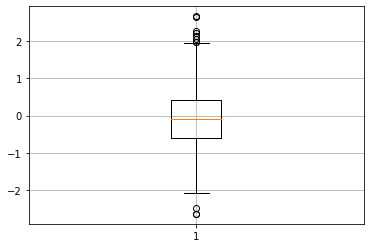

In [91]:
reds = np.asarray(reds)
plt.boxplot(reds)
plt.grid()
plt.show()